# Evaluate SAM1/SAM2

## ade20k sam1 sam2 comparison

In [1]:
#Code to evaluate SAM2 with 64 images from ade20k
%load_ext autoreload
%autoreload 2
import os,sys
sys.path.append('./source/')
from source.sam import evaluate_sam, sam12_info
from source.eval_and_plotting import (SavedSamples, DiffSamples, SavedSamplesManager)
import matplotlib.pyplot as plt
from source.utils.mixed_utils import shaprint
import argparse
import numpy as np

# this prevents a weird bug with matplotlib
plt.imshow(np.random.rand(10,10))
plt.close()

### testing scritp before adding to eval_and_plotting.py

In [6]:
clear = True
save = True

names = sam12_info["names"]

ssm = SavedSamplesManager()
didx = DiffSamples("qual_ade20k_13").didx

eval_sam_kwargs = argparse.Namespace(datasets="ade20k",
                                    model_type=0,
                                    num_return_segments=len(didx),
                                    split="vali",
                                    ratio_of_dataset=len(didx),
                                    generator_kwargs={},
                                    pri_didx=didx,
                                    longest_side_resize=1024,
                                    batch_size=4,
                                    postprocess_kwargs=None,
                                    full_resolution_decoder=False)

for name in names:
    eval_sam_kwargs.__dict__.update({"model_type":name})
    metrics_mean, light_data, heavy_data = evaluate_sam(**vars(eval_sam_kwargs))

    break

    sam_samples = SavedSamples(light_data=light_data,heavy_data=heavy_data,name=name)
    sam_samples2 = sam_samples.clone(f"{sam_samples.name}_areapost")
    if save:
        
    if clear:
        sam_samples.clear_heavy_data()
        sam_samples2.clear_heavy_data()

    ssm.add_saved_samples(sam_samples)
    ssm.add_saved_samples(sam_samples2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
processing dataset:  ade20k
evaluating 16 batches


100%|██████████| 16/16 [02:31<00:00,  9.49s/it]


In [ ]:
sam_samples = SavedSamples(light_data=light_data,heavy_data=heavy_data,name=name)
save_path = f"saves/sam_eval/sam12_comp/{name}_64_ade20k.pt"
sam_samples.save(save_path)
ssm = SavedSamplesManager(sam_samples)
ssm.plot_qual_seg()

In [6]:
import matplotlib
matplotlib.use('Qt5Agg')

/tmp/ipykernel_1230617/305297647.py:2: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use('Qt5Agg')


### plotting

In [2]:
name = sam12_info["names"][0]
save_path = f"saves/sam_eval/sam12_comp/{name}_64_ade20k.pt"
sam_samples = SavedSamples()
sam_samples.load(save_path)
ssm = SavedSamplesManager(sam_samples)

In [13]:
import matplotlib
#show backend
matplotlib.get_backend()
#set backend to inline
%matplotlib inline

(-0.5, 572.5, 422.5, -0.5)

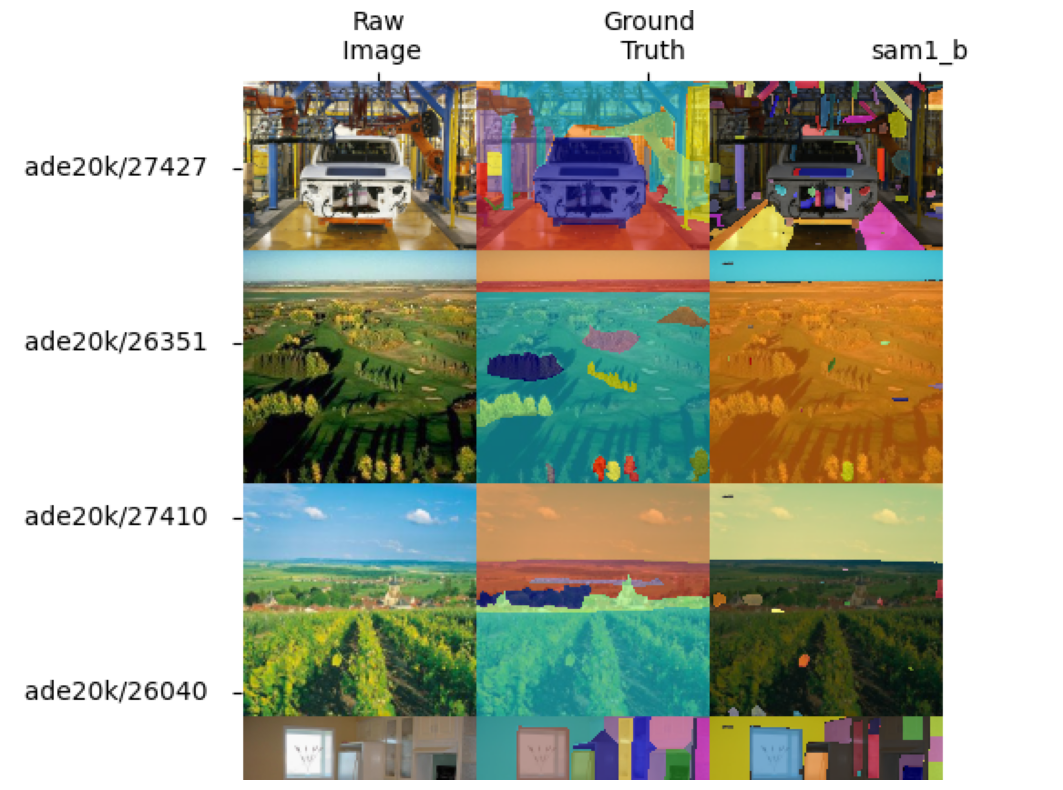

In [25]:
im = ssm.plot_qual_seg(transpose=False,add_text_axis=True)

fig = plt.figure(figsize=(20,10))
plt.imshow(im)
plt.axis("off")